# **AeroPulse: An Exploratory Analysis of Airline Experience Drivers**

![Cover image](./assets/cover.png)

Airlines collect enormous volumes of customer feedback—ratings, surveys, and long-form reviews. Despite this abundance, improvement efforts are often guided by surface-level heuristics:

> *“Customers complain a lot about X, so fixing X must improve satisfaction.”*

This assumption is flawed.

The most frequently discussed aspects of an experience are **not necessarily the most influential ones**. Some issues are highly visible but marginal in impact, while others are mentioned infrequently yet disproportionately shape overall perception.

**AeroPulse** is an exploratory, interpretability-first analysis that focuses on a single question:

> **When customers express sentiment about a specific aspect of their airline experience, how strongly is that sentiment associated with their overall satisfaction?**

This is **not** a predictive model, a churn analysis, or a causal inference study.
It is an **influence analysis**, grounded in observed associations and designed to surface *high-leverage experience drivers* without over-claiming or automation-heavy abstractions.

---

### **Business Objective**

The goal of this analysis is to **identify experience dimensions that exert disproportionate influence on overall satisfaction**, using methods that remain transparent, defensible, and easy to reason about.

Rather than optimizing for prediction accuracy, this work prioritizes:

* Interpretability
* Alignment between text, ratings, and conclusions
* Methodological restraint

---

### **Dataset Overview and Known Biases**

The dataset consists of approximately **5,100 airline reviews** scraped from `airlinequality.com` for **United Airlines**. Each review includes:

* Free-text narrative feedback
* Aspect-level ratings (seat comfort, cabin staff, food & beverage, ground service, value for money)
* An overall satisfaction score
* A binary recommendation flag

This dataset is **not representative of the full passenger population**. Several biases are inherent and explicitly acknowledged:

* **Self-selection bias** (motivated reviewers are overrepresented)
* **Negativity bias** (dissatisfied customers are more likely to leave feedback)
* **Non-uniform aspect completion**

Rather than attempting to correct for these effects, the analysis treats them as part of the signal and focuses on **relative influence**, not absolute satisfaction levels.

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configs
warnings.filterwarnings("ignore")

# pandas config
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_csv('../Data/reviews.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5122 entries, 0 to 5121
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   review_id               5122 non-null   int64  
 1   review_date             5122 non-null   object 
 2   flight_date             4386 non-null   object 
 3   route_origin            4361 non-null   object 
 4   route_destination       4361 non-null   object 
 5   aircraft_model          1167 non-null   object 
 6   seat_class              5120 non-null   object 
 7   traveler_type           0 non-null      float64
 8   trip_verified_flag      5122 non-null   bool   
 9   recommended_flag        5122 non-null   bool   
 10  overall_rating_10       5121 non-null   float64
 11  seat_comfort_rating     4933 non-null   float64
 12  cabin_staff_rating      4919 non-null   float64
 13  food_beverage_rating    3917 non-null   float64
 14  ground_service_rating   4293 non-null   

In [5]:
# `traveler_type` is a scraping artifact, we can remove this safely
df = df.drop(columns=['traveler_type'])

In [6]:
df.isnull().sum()

review_id                    0
review_date                  0
flight_date                736
route_origin               761
route_destination          761
aircraft_model            3955
seat_class                   2
trip_verified_flag           0
recommended_flag             0
overall_rating_10            1
seat_comfort_rating        189
cabin_staff_rating         203
food_beverage_rating      1205
ground_service_rating      829
value_for_money_rating       0
review_title                 0
review_text                  0
traveller_type             729
dtype: int64

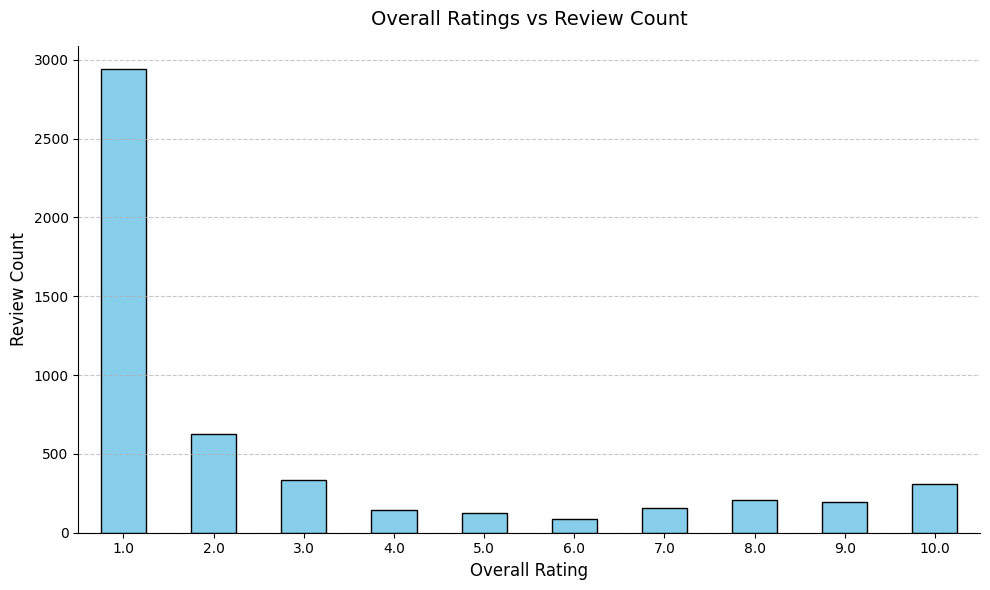

In [7]:
# overall rating distribution
ax = df['overall_rating_10'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(10, 6),
    color='skyblue',
    edgecolor='black',
    rot=0 
)

ax.set_title('Overall Ratings vs Review Count', fontsize=14, pad=15)
ax.set_xlabel('Overall Rating', fontsize=12)
ax.set_ylabel('Review Count', fontsize=12)

ax.yaxis.grid(True, linestyle='--', alpha=0.7)  
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [8]:
df.groupby("seat_class")["overall_rating_10"].describe().sort_values(by="mean", ascending=False)

,count,mean,std,min,25%,50%,75%,max
seat_class,,,,,,,,
business class,398.00,4.59,3.39,1.00,1.00,3.00,8.00,10.00
first class,289.00,4.01,3.30,1.00,1.00,2.00,7.00,10.00
premium economy,415.00,3.70,3.25,1.00,1.00,2.00,7.00,10.00
economy class,4017.00,2.48,2.68,1.00,1.00,1.00,2.00,10.00


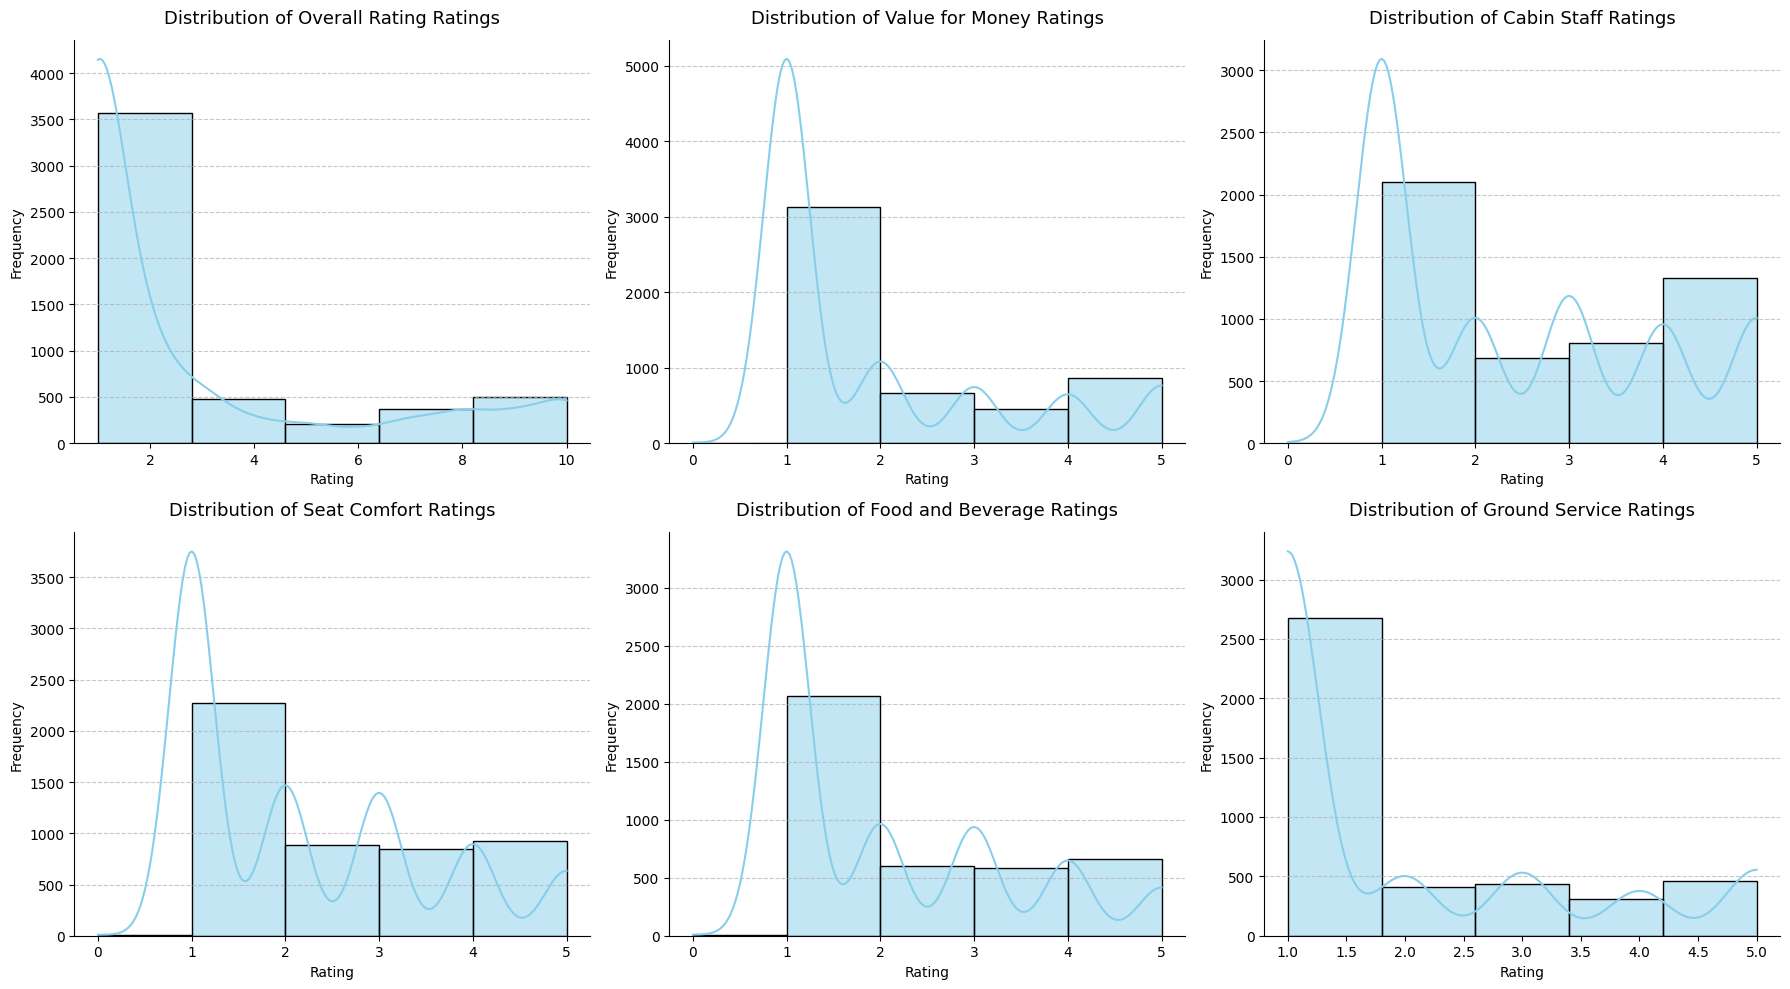

In [9]:
cols = [
    'overall_rating_10', 'value_for_money_rating', 'cabin_staff_rating', 'seat_comfort_rating',
    'food_beverage_rating', 'ground_service_rating'
]
titles = [
    'Overall Rating', 'Value for Money', 'Cabin Staff', 'Seat Comfort', 
    'Food and Beverage', 'Ground Service'
]

# Initialize a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]

    sns.histplot(df[col], bins=5, kde=True, ax=ax, color='skyblue', edgecolor='black')
    
    # Titles and labels
    ax.set_title(f'Distribution of {titles[i]} Ratings', fontsize=13, pad=12)
    ax.set_xlabel('Rating', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.spines[['top', 'right']].set_visible(False)


plt.tight_layout()
plt.show()

### **Aspect Rating Distributions: First-Order Signals**

Before analyzing language, it is useful to understand how customers score individual experience dimensions.

Several consistent patterns emerge across aspect ratings:

* **Value for Money** exhibits a strong negative skew, with a dominant peak at the lowest rating. This suggests a widespread perception that price does not align with service quality.

* **Seat Comfort** ratings cluster heavily at the lowest end, with only a thin tail into higher values. This indicates that physical comfort issues are both common and severe.

* **Food & Beverage** follows a distribution nearly identical to seat comfort, suggesting it is another area of systematic dissatisfaction rather than sporadic failure.

* **Cabin Staff** displays a notably different shape. While still negatively skewed, it shows a visible secondary peak at higher ratings, indicating polarized experiences and occasional standout interactions.

* **Ground Service** is the most uniformly negative dimension, with almost all ratings concentrated at the lowest level and minimal mid-range or positive feedback.

These distributions provide important context—but **frequency and severity alone do not imply influence**. A negatively skewed aspect may be highly visible yet have limited marginal impact on overall satisfaction. That distinction is examined later.

In [10]:
# Basic text diagnostics
df["review_text_len"] = df["review_text"].str.len()
df["review_word_count"] = df["review_text"].str.split().str.len()

df[["review_text_len", "review_word_count"]].describe(percentiles=[0.05, 0.1, 0.5, 0.9, 0.95]).T

,count,mean,std,min,5%,10%,50%,90%,95%,max
review_text_len,5122.00,854.14,587.80,111.00,262.00,317.00,680.00,1616.00,2070.90,4908.00
review_word_count,5122.00,157.64,110.18,17.00,47.00,57.00,125.00,298.00,384.95,957.00


In [11]:
correlation = df['overall_rating_10'].corr(df['review_text_len'])
print(f"Correlation between Overall Rating and Review Length: {correlation:.2f}")

Correlation between Overall Rating and Review Length: -0.10


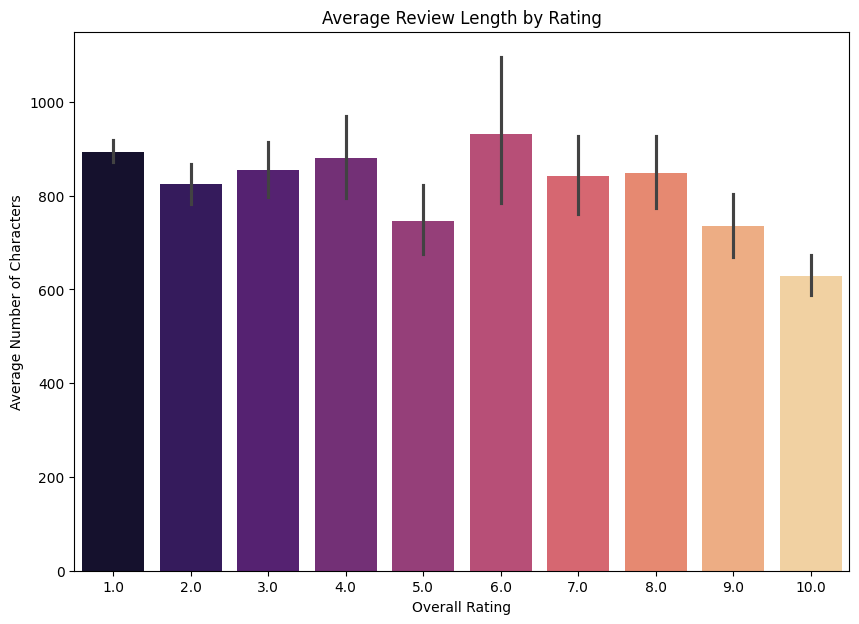

In [12]:
plt.figure(figsize=(10, 7))

# Calculating the mean length for each rating to see the trend
sns.barplot(data=df, x='overall_rating_10', y='review_text_len', palette='magma', estimator='mean')

plt.title('Average Review Length by Rating')
plt.xlabel('Overall Rating')
plt.ylabel('Average Number of Characters')
plt.show()

In [13]:
rating_cols = [
    "overall_rating_10",
    "seat_comfort_rating",
    "cabin_staff_rating",
    "food_beverage_rating",
    "ground_service_rating",
    "value_for_money_rating"
]

# Missingness summary
missing_summary = (
    df[rating_cols]
    .isna()
    .mean()
    .sort_values(ascending=False)
)

missing_summary

food_beverage_rating     0.24
ground_service_rating    0.16
cabin_staff_rating       0.04
seat_comfort_rating      0.04
overall_rating_10        0.00
value_for_money_rating   0.00
dtype: float64

In [14]:
df["num_ratings_present"] = df[rating_cols].notna().sum(axis=1)
df["num_ratings_present"].value_counts().sort_index()

num_ratings_present
2      89
3     100
4      16
5    1739
6    3178
Name: count, dtype: int64

In [15]:
# Recommendation vs overall rating
df.groupby("recommended_flag")["overall_rating_10"].describe()

,count,mean,std,min,25%,50%,75%,max
recommended_flag,,,,,,,,
False,4149.00,1.56,1.09,1.00,1.00,1.00,2.00,10.00
True,972.00,8.27,1.76,1.00,7.00,9.00,10.00,10.00


In [16]:
# review length vs sentiment
df.groupby("recommended_flag")["review_word_count"].describe()

,count,mean,std,min,25%,50%,75%,max
recommended_flag,,,,,,,,
False,4150.00,162.43,113.58,24.00,85.00,128.50,203.75,957.00
True,972.00,137.17,91.58,17.00,77.00,112.50,169.25,629.00


### **Methodological Constraints and Design Decisions**

Several non-obvious analytical choices are critical to the validity of this study.

---

#### **Text Handling**

* Reviews are long-form, with a median length of approximately 125 words.
* Even short reviews typically contain semantically meaningful feedback.

As a result, **no minimum text-length filtering** is applied. Excluding short reviews would disproportionately remove concise but emotionally strong feedback.

---

#### **Temporal Treatment**

* Review dates are parsed precisely.
* Flight dates are available only at month-level granularity.

No lag-based or time-series inference is performed. Temporal information is treated as coarse context rather than a causal signal.

---

#### **Interpretation of Missing Ratings**

Aspect ratings exhibit systematic missingness:

* Food & beverage and ground service are frequently unrated
* Seat comfort and value for money are almost always rated

Missing ratings are interpreted as **non-salience**, not neutrality.
Accordingly:

* No rating imputation is performed
* Aspect sentiment is computed **only when the aspect is explicitly mentioned in text**

All influence estimates are therefore **conditional on aspect mention** and should be interpreted as *within-aspect contrasts*, not population-wide effects.

---

### **Aspect Anchoring Strategy**

Aspect-based text analysis is prone to over-interpretation when aspects are discovered automatically.

To preserve interpretability and alignment, this analysis **anchors all text-based aspects directly to the airline’s existing rating dimensions**:

* Seat comfort
* Cabin staff
* Food & beverage
* Ground service
* Value for money

No additional aspects (e.g., delays, aircraft age) are introduced, even if mentioned in text. This ensures consistency between:

* What customers say
* What customers score
* What conclusions are drawn


In [17]:
# strip whitespaces & normalize casing
df["review_text_clean"] = (
    df["review_text"]
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

In [18]:
ASPECT_KEYWORDS = {
    "seat_comfort": [
        "seat", "legroom", "leg room", "recline", "cramped",
        "comfort", "uncomfortable", "aisle", "window seat"
    ],
    "cabin_staff": [
        "crew", "staff", "attendant", "flight attendant",
        "service", "hospitality", "rude", "friendly", "helpful"
    ],
    "food_beverage": [
        "food", "meal", "drink", "beverage", "snack",
        "dinner", "lunch", "breakfast", "wine", "coffee"
    ],
    "ground_service": [
        "check-in", "check in", "boarding", "gate",
        "baggage", "luggage", "security", "counter", "staff at airport"
    ],
    "value_money": [
        "price", "cost", "value", "worth", "money",
        "expensive", "cheap", "overpriced", "paid"
    ]
}

In [19]:
import re

def detect_aspects(text, aspect_keywords):
    text_lower = text.lower()
    detected = {}
    for aspect, keywords in aspect_keywords.items():
        detected[aspect] = any(
            re.search(rf"\b{re.escape(keyword)}\b", text_lower)
            for keyword in keywords
        )
    return detected

In [20]:
aspect_flags = df["review_text_clean"].apply(
    lambda x: detect_aspects(x, ASPECT_KEYWORDS)
)

aspect_df = pd.DataFrame(aspect_flags.tolist())

df = pd.concat([df, aspect_df], axis=1)

df[list(ASPECT_KEYWORDS.keys())].head()

,seat_comfort,cabin_staff,food_beverage,ground_service,value_money
0,False,False,False,False,True
1,True,False,False,True,False
2,False,True,False,False,False
3,False,False,False,True,True
4,True,False,True,False,False


In [21]:
coverage = {}

for aspect, rating_col in {
    "seat_comfort": "seat_comfort_rating",
    "cabin_staff": "cabin_staff_rating",
    "food_beverage": "food_beverage_rating",
    "ground_service": "ground_service_rating",
    "value_money": "value_for_money_rating"
}.items():
    coverage[aspect] = {
        "text_mention_rate": df[aspect].mean(),
        "rating_present_rate": df[rating_col].notna().mean(),
        "both_text_and_rating": ((df[aspect]) & (df[rating_col].notna())).mean()
    }

pd.DataFrame(coverage).T

,text_mention_rate,rating_present_rate,both_text_and_rating
seat_comfort,0.27,0.96,0.27
cabin_staff,0.67,0.96,0.65
food_beverage,0.28,0.76,0.26
ground_service,0.44,0.84,0.38
value_money,0.27,1.00,0.27


In [22]:
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/kannan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/kannan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
df["sentences"] = df["review_text_clean"].apply(sent_tokenize)

In [24]:
def extract_aspect_sentences(sentences, keywords):
    matched = []
    for sent in sentences:
        sent_lower = sent.lower()
        if any(k in sent_lower for k in keywords):
            matched.append(sent)
    return matched

In [25]:
def extract_aspect_sentences(sentences, keywords):
    matched = []
    for sent in sentences:
        sent_lower = sent.lower()
        if any(k in sent_lower for k in keywords):
            matched.append(sent)
    return matched

In [26]:
for aspect, keywords in ASPECT_KEYWORDS.items():
    df[f"{aspect}_sentences"] = df["sentences"].apply(
        lambda sents: extract_aspect_sentences(sents, keywords)
    )

In [27]:
df[[f"{a}_sentences" for a in ASPECT_KEYWORDS.keys()]].head(3)

,seat_comfort_sentences,cabin_staff_sentences,food_beverage_sentences,ground_service_sentences,value_money_sentences
0,[],[],[],[],[I would rather spend twice the money and fly ...
1,"[United didn’t give my husband a seat number, ...",[],[],"[United didn’t give my husband a seat number, ...",[]
2,"[Seats were comfortable, plane was well mainta...",[Crew is professional.],[They served drinks before takeoff which is ni...,[],[]


In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

def sentiment_score(sentences):
    if not sentences:
        return None
    scores = [sia.polarity_scores(s)["compound"] for s in sentences]
    return sum(scores) / len(scores)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kannan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
for aspect in ASPECT_KEYWORDS.keys():
    df[f"{aspect}_sentiment"] = df[f"{aspect}_sentences"].apply(sentiment_score)

In [30]:
sentiment_cols = [f"{a}_sentiment" for a in ASPECT_KEYWORDS.keys()]
df[sentiment_cols].describe()

,seat_comfort_sentiment,cabin_staff_sentiment,food_beverage_sentiment,ground_service_sentiment,value_money_sentiment
count,2117.00,3599.00,1614.00,2347.00,1619.00
mean,0.06,-0.01,0.05,-0.03,0.05
std,0.40,0.44,0.42,0.34,0.38
min,-0.96,-0.98,-0.96,-0.93,-0.91
25%,-0.18,-0.35,-0.25,-0.24,-0.20
50%,0.00,-0.01,0.00,0.00,0.00
75%,0.34,0.32,0.35,0.15,0.30
max,0.99,0.99,0.98,0.99,0.99


In [31]:
df[sentiment_cols].notna().mean().sort_values(ascending=False)

cabin_staff_sentiment      0.70
ground_service_sentiment   0.46
seat_comfort_sentiment     0.41
value_money_sentiment      0.32
food_beverage_sentiment    0.32
dtype: float64

In [32]:
impact_df = df[
    ["overall_rating_10"] +
    [f"{a}_sentiment" for a in ASPECT_KEYWORDS.keys()]
].copy()

In [33]:
from scipy.stats import spearmanr


impact_results = {}

for aspect in ASPECT_KEYWORDS.keys():
    sub = impact_df[
        impact_df[f"{aspect}_sentiment"].notna()
    ][["overall_rating_10", f"{aspect}_sentiment"]]

    corr, pval = spearmanr(
        sub[f"{aspect}_sentiment"],
        sub["overall_rating_10"]
    )

    impact_results[aspect] = {
        "n": len(sub),
        "spearman_corr": corr,
        "p_value": pval
    }

impact_corr_df = pd.DataFrame(impact_results).T.sort_values(
    "spearman_corr", ascending=False
)

impact_corr_df

,n,spearman_corr,p_value
food_beverage,1614.00,0.49,0.00
seat_comfort,2117.00,0.46,0.00
ground_service,2347.00,0.26,0.00
value_money,1619.00,0.24,0.00
cabin_staff,3599.00,NaN,NaN


In [34]:
def sentiment_bucket(x):
    if x <= -0.05:
        return "negative"
    elif x >= 0.05:
        return "positive"
    else:
        return "neutral"

In [35]:
lift_results = {}

for aspect in ASPECT_KEYWORDS.keys():
    sub = df[
        df[f"{aspect}_sentiment"].notna()
    ].copy()

    sub["sentiment_bucket"] = sub[f"{aspect}_sentiment"].apply(sentiment_bucket)

    means = sub.groupby("sentiment_bucket")["overall_rating_10"].mean()

    lift_results[aspect] = {
        "n": len(sub),
        "rating_negative": means.get("negative", None),
        "rating_neutral": means.get("neutral", None),
        "rating_positive": means.get("positive", None),
        "lift_pos_vs_neg": (
            means.get("positive", None) - means.get("negative", None)
            if means.get("positive", None) is not None and means.get("negative", None) is not None
            else None
        )
    }

impact_lift_df = pd.DataFrame(lift_results).T.sort_values(
    "lift_pos_vs_neg", ascending=False
)

impact_lift_df

,n,rating_negative,rating_neutral,rating_positive,lift_pos_vs_neg
food_beverage,1614.00,2.40,3.61,5.89,3.49
cabin_staff,3599.00,1.67,2.43,5.14,3.48
seat_comfort,2117.00,2.02,2.92,5.07,3.05
ground_service,2347.00,1.94,2.51,3.94,1.99
value_money,1619.00,1.67,2.09,2.93,1.25


In [36]:
viz_df = pd.DataFrame({
    "aspect": impact_lift_df.index,
    "lift": impact_lift_df["lift_pos_vs_neg"],
    "coverage": [
        df[a].mean() for a in impact_lift_df.index
    ],
    "n": impact_lift_df["n"]
})

viz_df

,aspect,lift,coverage,n
food_beverage,food_beverage,3.49,0.28,1614.00
cabin_staff,cabin_staff,3.48,0.67,3599.00
seat_comfort,seat_comfort,3.05,0.27,2117.00
ground_service,ground_service,1.99,0.44,2347.00
value_money,value_money,1.25,0.27,1619.00


Which experiences disproportionately influence overall satisfaction?

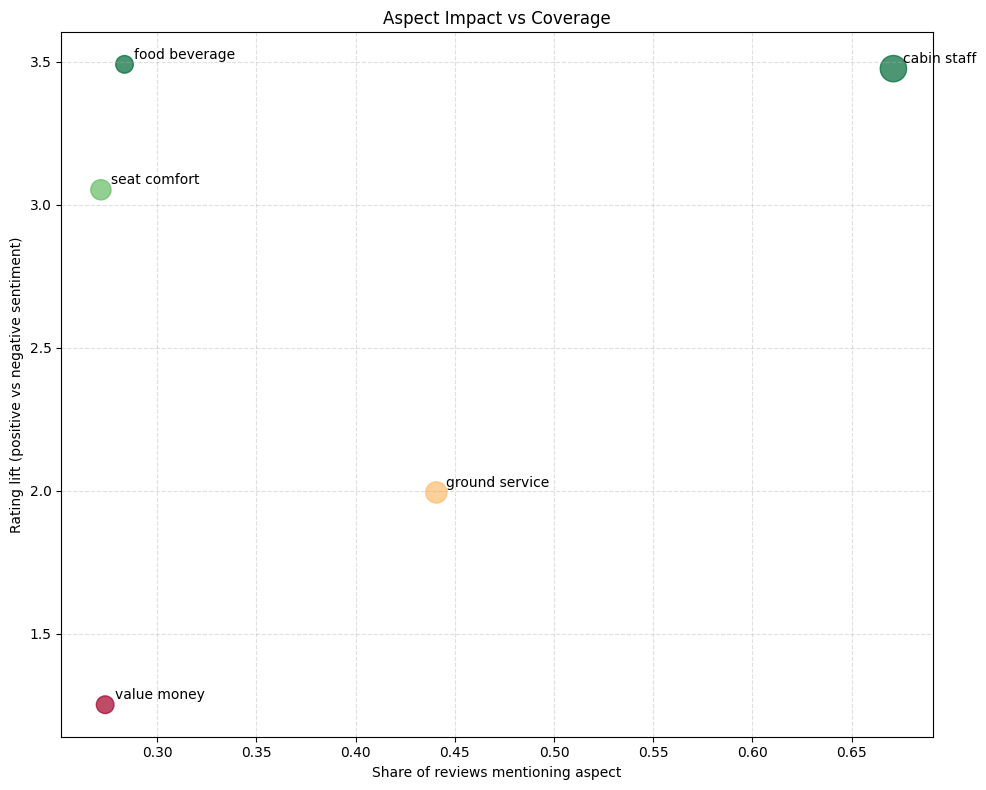

In [39]:
plt.figure(figsize=(10, 8))

plt.scatter(
    viz_df["coverage"],
    viz_df["lift"],
    s=viz_df["n"] / 10,
    alpha=0.7,
    c=viz_df["lift"],  # Color by lift
    cmap="RdYlGn",     # Red-Yellow-Green gradient
)

for _, row in viz_df.iterrows():
    plt.text(
        row["coverage"] + 0.005,
        row["lift"] + 0.02,
        row["aspect"].replace("_", " "),
        fontsize=10
    )

plt.xlabel("Share of reviews mentioning aspect")
plt.ylabel("Rating lift (positive vs negative sentiment)")
plt.title(
    "Aspect Impact vs Coverage"
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

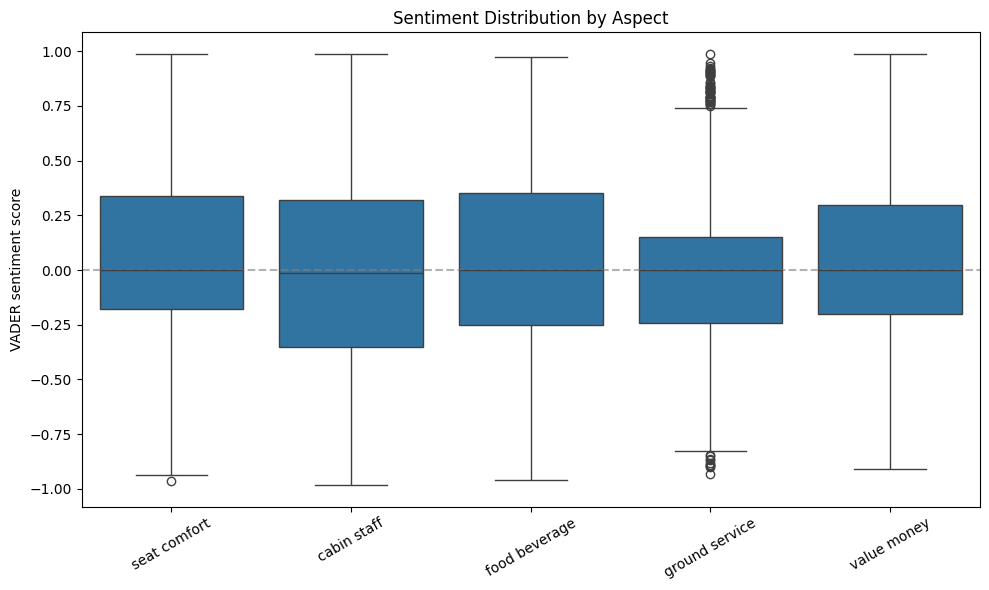

In [40]:
sentiment_long = df.melt(
    value_vars=[f"{a}_sentiment" for a in ASPECT_KEYWORDS.keys()],
    var_name="aspect",
    value_name="sentiment"
).dropna()

sentiment_long["aspect"] = sentiment_long["aspect"].str.replace("_sentiment", "").str.replace("_", " ")

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=sentiment_long,
    x="aspect",
    y="sentiment"
)

plt.axhline(0, color="gray", linestyle="--", alpha=0.6)
plt.title("Sentiment Distribution by Aspect")
plt.xlabel("")
plt.ylabel("VADER sentiment score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

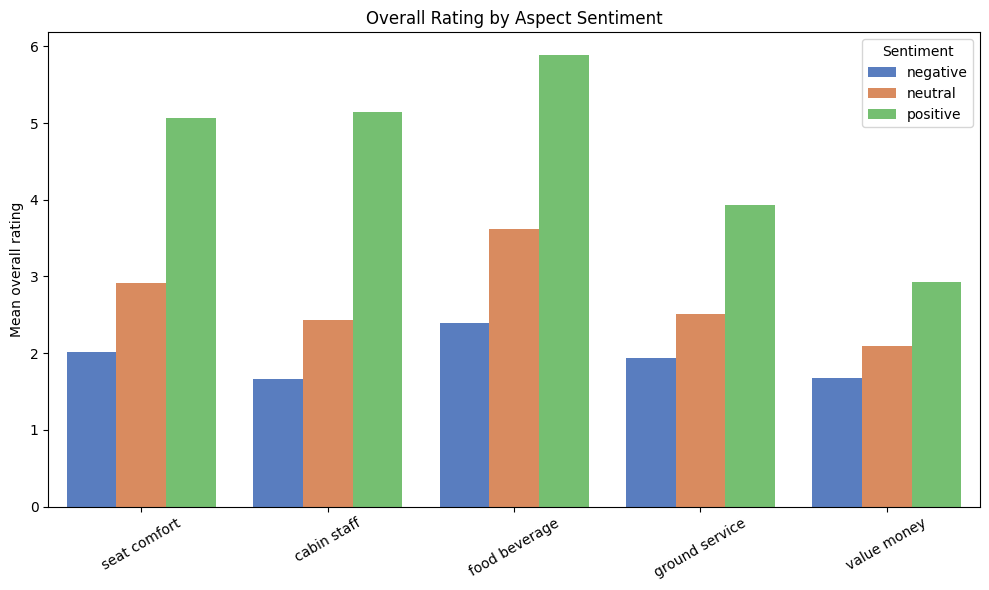

In [41]:
bucket_plot_df = []

for aspect in ASPECT_KEYWORDS.keys():
    sub = df[df[f"{aspect}_sentiment"].notna()].copy()
    sub["sentiment_bucket"] = sub[f"{aspect}_sentiment"].apply(sentiment_bucket)
    means = sub.groupby("sentiment_bucket")["overall_rating_10"].mean().reset_index()
    means["aspect"] = aspect.replace("_", " ")
    bucket_plot_df.append(means)

bucket_plot_df = pd.concat(bucket_plot_df)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=bucket_plot_df,
    x="aspect",
    y="overall_rating_10",
    hue="sentiment_bucket",
    palette="muted"
)

plt.title("Overall Rating by Aspect Sentiment")
plt.ylabel("Mean overall rating")
plt.xlabel("")
plt.xticks(rotation=30)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

### **From Frequency to Influence**

Aspect mention frequency varies substantially:

* Cabin staff dominates discussion
* Seat comfort and ground service are moderately salient
* Food & beverage and value for money appear selectively

At this point, many analyses stop. That is where they go wrong.

**High mention frequency does not imply high influence.**

---

### **Sentiment Extraction Approach**

Sentiment is extracted using a **rule-based VADER approach**, applied at the **sentence level** and restricted to **aspect-relevant sentences only**.

This design avoids:

* Diluting sentiment across unrelated topics
* Assigning emotion where none exists
* Opaque, black-box behavior

Across aspects, sentiment distributions are centered near neutral, with emotional intensity concentrated in the tails—consistent with realistic customer feedback dynamics.

---

### **Defining and Measuring Influence**

Influence is defined as:

> **The change in overall satisfaction when sentiment about an aspect shifts from negative to positive.**

Two complementary measures are used:

1. **Directional lift** (primary metric)
2. **Spearman rank correlation** (supporting evidence where valid)

Lift is prioritized because correlation alone becomes unreliable under rating saturation, heavy class imbalance, and tied ranks.

---

### **Key Findings**

A clear hierarchy of influence emerges:

* **Food & beverage quality** exhibits the largest marginal impact despite lower discussion frequency
* **Cabin staff behavior** acts as an emotional amplifier
* **Seat comfort** functions as a baseline requirement, where failures are highly penalized
* **Value for money** reflects cumulative judgment rather than a directly actionable touchpoint

Some aspects operate as **“silent killers”**—rarely discussed, yet disproportionately influential.

---

### **Implications and Limits**

* Efforts focused solely on improving “value for money” perception are unlikely to yield large satisfaction gains.
* Improvements in food quality, consistency, and staff interactions offer high leverage.
* Seat comfort failures should be treated as high-risk defects, not minor inconveniences.

This analysis does **not** claim causality and does **not** generalize beyond the studied airline. Potential extensions—temporal analysis, cross-airline comparison, or embedding-based aspect discovery—should preserve the interpretability constraints used here.
